In [1]:
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')


RendererRegistry.enable('jupyterlab')

In [88]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")

## Question 1:

1) Make the scatteplot

In [200]:
genre_stats = mxmh.groupby('Fav genre', as_index=False).agg(
    avg_age=('Age', 'mean'),
    count=('Age', 'count')
)

max_y = mxmh.groupby("Age_Grouped")["Fav genre"].count().max()
max_y = min(max_y, 100)

x_range = [10, 70]

color_scale = alt.Scale(domain=genre_stats['Fav genre'].tolist(), scheme='tableau20')

selection = alt.selection_point(
    fields=['Fav genre'],
    nearest=True,
    on='mouseover',
    clear='mouseout',  
    empty='none'
)

avg_age_chart = alt.Chart(genre_stats).mark_circle(size=200).encode(
    y=alt.Y('Fav genre:N', title="Genre", sort='-x'),
    x=alt.X('avg_age:Q', title="Average Age", scale=alt.Scale(domain=[10, 60])),
    color=alt.condition(selection, alt.Color('Fav genre:N', scale=color_scale, legend=None), alt.value('black')),
    tooltip=[
    alt.Tooltip('avg_age:Q', title='Average Age', format=".2f"),
    alt.Tooltip('count:Q', title='Number of Respondents')],
    size=alt.Size('count:Q', title="Count"),
).add_params(
    selection
)

genre_labels = alt.Chart(genre_stats).mark_text(
    align='left',
    baseline='middle',
    dx=10  
).encode(
    y=alt.Y('Fav genre:N', sort='-x', axis=alt.Axis(labels=False, ticks=True, domain=True)),
    x=alt.X('avg_age:Q'),
    text=alt.Text('Fav genre:N'),
    color=alt.condition(selection, alt.Color('Fav genre:N', scale=color_scale), alt.value('gray'))
)

avg_age_chart_with_labels = alt.layer(
    avg_age_chart,
    genre_labels
).properties(
    width=500,
    height=400
)

overall_avg_age = mxmh['Age'].mean()
avg_age_line = alt.Chart(pd.DataFrame({'x': [overall_avg_age]})).mark_rule(
    color='red',
    strokeWidth=2, 
    opacity=0.2
).encode(
    x='x:Q'
).properties(
    width=500,
    height=400
)

scatter_plot_with_line = alt.layer(
    avg_age_line,
    avg_age_chart_with_labels,
)

In [219]:
age_hist = alt.Chart(mxmh).mark_bar().encode(
    alt.X('Age_Grouped:Q', bin=alt.Bin(step=5), title="Grouped Ages", scale=alt.Scale(domain=x_range)),
    alt.Y('count()', title="Count", scale=alt.Scale(domain=[0, max_y])),
    color=alt.condition(selection, alt.Color('Fav genre:N', scale=color_scale), alt.value('lightgray'))
).transform_filter(
    selection
)

static_axis = alt.Chart(mxmh).transform_aggregate(
    count='count()', groupby=['Age_Grouped']
).transform_calculate(
    capped_count='min(datum.count, 70)' 
).mark_bar(
    opacity=0
).encode(
    x=alt.X('Age_Grouped:Q', title="Grouped Ages", scale=alt.Scale(domain=x_range), axis=alt.Axis(grid=False)),
    y=alt.Y('capped_count:Q', title="Count", scale=alt.Scale(domain=[0, max_y]))
).properties(
    width=300,
    height=300
)

histogram = alt.layer(static_axis, age_hist).properties(
    width=300,
    height=300 
)


dynamic_title = alt.Chart(genre_stats).mark_text(
    align='center',
    baseline='middle',
    fontSize=20,
    fontWeight='bold'
).encode(
    text='Fav genre:N',
    opacity=alt.condition(selection, alt.value(1), alt.value(0)) 
).add_params(
    selection
).properties(
    width=300,
    height=60
)

histogram_with_title = alt.vconcat(
    dynamic_title,
    histogram
)

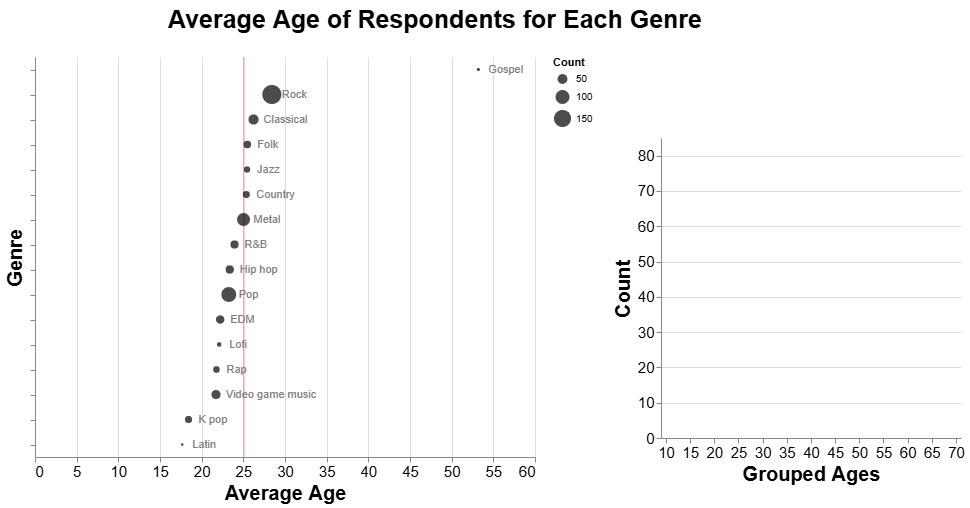

In [220]:
title = alt.Chart().mark_text(
    text="Average Age of Respondents for Each Genre",
    fontSize=25,
    fontWeight='bold',
    align='center'
).properties(
    width=800,
    height=30
)

main = alt.hconcat(
    scatter_plot_with_line,
    histogram_with_title
).resolve_scale(
    size='independent'
)

chart = alt.vconcat(
    title,
    main
).configure_axis(
    labelFontSize=15,
    titleFontSize=20
).configure_view(
    stroke=None
)

chart

## Question 2

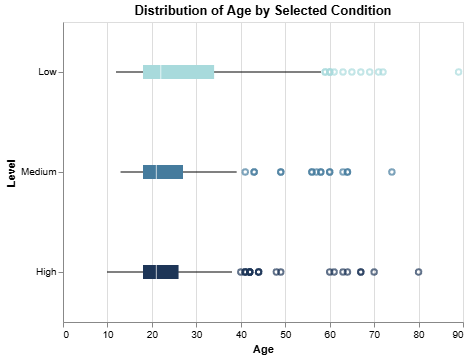

In [290]:

mental_health_long = mxmh.melt(
    id_vars='Age',
    value_vars=['Anxiety_Level', 'Depression_Level', 'Insomnia_Level', 'OCD_Level'],
    var_name='Category',
    value_name='Level'
)


condition_param = alt.param(
    name='selected_condition',
    bind=alt.binding_select(
        options=['Anxiety_Level', 'Depression_Level', 'Insomnia_Level', 'OCD_Level'],
        name='Select Category: '
    ),
    value='Anxiety_Level'
)

color_scale = alt.Scale(
    domain=['Low', 'Medium', 'High'],
    range=['#a8dadc', '#457b9d', '#1d3557']  # light to dark blues
)

box = alt.Chart(mental_health_long).transform_filter(
    alt.datum.Category == condition_param
).mark_boxplot().encode(
    y=alt.Y('Level:N', title='Level', sort=['Low', 'Medium', 'High']),
    x=alt.X('Age:Q', title='Age'),
    color=alt.Color(
        'Level:N',
        scale=color_scale,
        legend=None
    )
).add_params(
    condition_param
).properties(
    width=400,
    height=300,
    title='Distribution of Age by Selected Condition'
)

box
